In [1]:
import pandas as pd
import numpy as np
from itertools import product
from string import ascii_uppercase
from astropy.table import Table

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve

import seaborn as sns

from ast import literal_eval
from collections import MutableMapping

In [2]:
data = Table.read('sgsep_cosmos_tests_v2.fits', format='fits')
df = data.to_pandas()

np.unique(df['TRUE_CLASS'],return_counts=True)

(array([0, 1], dtype=int16), array([103914,  12113]))

In [3]:
#len(df.columns)
df.columns
df_properties = df.iloc[:,3:30]
df_properties.columns

Index([u'MAG_AUTO_G', u'MAG_AUTO_R', u'MAG_AUTO_I', u'MAG_AUTO_Z',
       u'MAG_AUTO_Y', u'MAGERR_AUTO_G', u'MAGERR_AUTO_R', u'MAGERR_AUTO_I',
       u'MAGERR_AUTO_Z', u'MAGERR_AUTO_Y', u'MAG_CM_MOF_G', u'MAG_CM_MOF_R',
       u'MAG_CM_MOF_I', u'MAG_CM_MOF_Z', u'MAG_PSF_MOF_G', u'MAG_PSF_MOF_R',
       u'MAG_PSF_MOF_I', u'MAG_PSF_MOF_Z', u'CONCENTRATION_MOF_G',
       u'CONCENTRATION_MOF_R', u'CONCENTRATION_MOF_I', u'CONCENTRATION_MOF_Z',
       u'CLASS_STAR_I', u'SPREAD_MODEL_I', u'SPREADERR_MODEL_I', u'CM_T',
       u'CM_T_ERR'],
      dtype='object')

In [4]:
test_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]

## Exploring How Training Data Affects the False Classification Rates 
#### (Random Forest Algorithm)

In [5]:
def train(df, test_list):
    '''
    This function will record the rate of false binary classification based on the amount of data used to train vs test 
    for a given machine learning algorithm. This works for my specific dataframe (df) in this notebook.
    
    input: df - pandas dataframe
    output: Xtrain - training data
            y - truth for Xtrain
            Xtest - test data
            ytest - truth for Xtest
    '''
    df_properties = df.iloc[:,3:30] #photometric properties
    df_properties['TRUE_CLASS'] = df['TRUE_CLASS']
    tt = []
    for i in test_list:
        rows = len(df_properties.index)
        Xtrain = df_properties[:int(rows*i)]
        Xtest = df_properties[int(rows*i):]

        Xtrain = Xtrain.drop("TRUE_CLASS", axis=1)
        Xtest = Xtest.drop("TRUE_CLASS", axis=1)

        y = df_properties[:int(rows*i)]['TRUE_CLASS'] #training
        ytest = df_properties[int(rows*i):]['TRUE_CLASS']
        tt.append([i,Xtrain,y,Xtest,ytest])    
    return tt

In [6]:
tt = train(df,test_list)

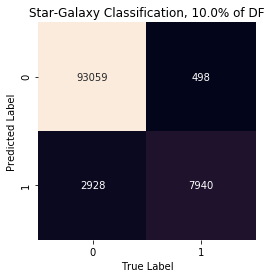

Completeness/Precision: 0.995
Purity: 0.969
Galaxy Contamination: 3.1 %


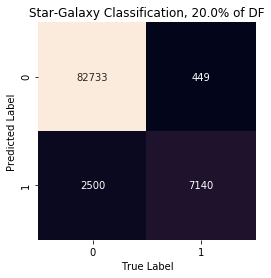

Completeness/Precision: 0.995
Purity: 0.971
Galaxy Contamination: 2.9 %


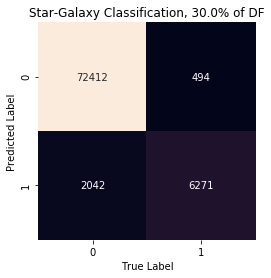

Completeness/Precision: 0.993
Purity: 0.973
Galaxy Contamination: 2.7 %


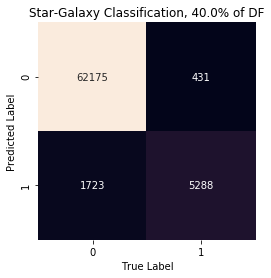

Completeness/Precision: 0.993
Purity: 0.973
Galaxy Contamination: 2.7 %


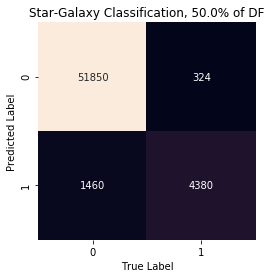

Completeness/Precision: 0.994
Purity: 0.973
Galaxy Contamination: 2.7 %


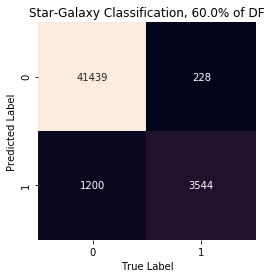

Completeness/Precision: 0.995
Purity: 0.972
Galaxy Contamination: 2.8 %


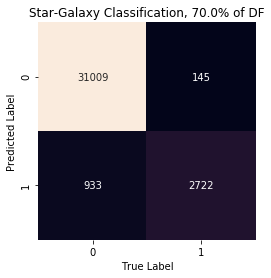

Completeness/Precision: 0.995
Purity: 0.971
Galaxy Contamination: 2.9 %


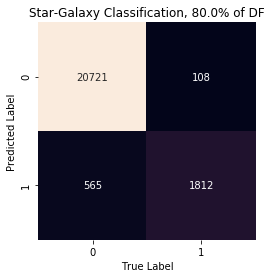

Completeness/Precision: 0.995
Purity: 0.973
Galaxy Contamination: 2.7 %


In [10]:
mats = [] #confusion matrices
conts = []
for i,Xtrain,y,Xtest,ytest in tt:
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(Xtrain,y)
    test = clf.predict(Xtest)
    mat = confusion_matrix(test,ytest)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    title = 'Star-Galaxy Classification, {trainratio}'.format(trainratio = str(i*100)+'% of DF')
    plt.title(title)
    plt.show()
    mats.append(mat)
    
    TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])

    print "Completeness/Precision:", round((TP/(TP+FN)),3) #sensitivity/true positive rate
    print "Purity:", round((TP/(TP+FP)),3) #precision 
    gal_cont = round((FP/(FP+TP)),3)*100
    conts.append(gal_cont)
    print "Galaxy Contamination:", gal_cont,'%' #when star is misclassified as galaxy

In [11]:
# check these false classification rates with other algorithms in their each percentage of training
# plot all of these, focus on the star classified as a galaxy and see which overlap is ideal?

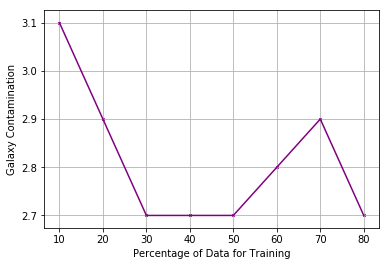

In [12]:
tl_perc = [i*100 for i in test_list]

plt.scatter(tl_perc,conts,s=5,color='purple')
plt.plot(tl_perc,conts,color='purple')
plt.xlabel('Percentage of Data for Training')
plt.ylabel('Galaxy Contamination')
plt.grid()
plt.show()

I'm going to use 30% of the data for training, and the rest for testing given the plot above. While it does seem a little arbitrary to use galaxy contamination as a metric, the number of false galaxy classifications did lower by 0.3%. There are way more true stars than true galaxies in the dataset, so that results in most of the false classifications being stars classified as galaxies.

#### To mitigate class imbalances in data, you can stratify the data and adjust the testing and training data accordingly. I'm going to see if we need to balance the data.

In [7]:
i,Xtrain,y,Xtest,ytest = tt[7] #80% of data for training

In [14]:
rows = df.shape[0]

In [15]:
unique_df = np.unique(df['TRUE_CLASS'], return_counts=True) #0 = galaxy, 1 = star
print round((float(unique_df[1][0])/df.shape[0])*100,3),"% of data in the whole DF is a star classification"
print round((float(unique_df[1][1])/df.shape[0])*100,3),"% of data in the whole DF is a galaxy classification"

89.56 % of data in the whole DF is a star classification
10.44 % of data in the whole DF is a galaxy classification


In [16]:
train_df = np.unique(df[:int(rows*0.3)]['TRUE_CLASS'], return_counts=True)

print round((float(train_df[1][0])/int(rows*0.3))*100,3),"% of data in the whole DF is a star classification"
print round((float(train_df[1][1])/int(rows*0.3))*100,3),"% of data in the whole DF is a galaxy classification"

89.083 % of data in the whole DF is a star classification
10.917 % of data in the whole DF is a galaxy classification


In [17]:
test_df = np.unique(df[int(rows*0.3):]['TRUE_CLASS'], return_counts=True)

print round((float(test_df[1][0])/int(rows*0.7))*100,3),"% of data in the whole DF is a star classification"
print round((float(test_df[1][1])/int(rows*0.7))*100,3),"% of data in the whole DF is a galaxy classification"

89.766 % of data in the whole DF is a star classification
10.235 % of data in the whole DF is a galaxy classification


We see that the percentages of star and galaxy classifications in the training dataset matches the percentages of star and galaxy classifications in the testing dataset. The data is already stratified because of the similar ratios of classes in both training and testing data.

## Scikit-Learn: Utilizing Different Machine Learning Algorithms

#### Utilizing classification_report -  precision, recall, f1-score

Precision = TP / (TP + FP) <br>
Recall - TP / (TP + FN) <br>
F1 Score - Harmonic mean of precision and recall

In [18]:
pr_list = [] #(precision, recall) in order of ADA,RandomForest,DecisionTree,ExtraTrees,KNeighbors
galaxy_conts = []

In [19]:
#AdaBoost

clf = AdaBoostClassifier(n_estimators=50)
clf.fit(Xtrain,y)

for i in range(len(Xtrain.columns)):
    print Xtrain.columns[i],clf.feature_importances_[i]
#print(clf.feature_importances_)
#print(Xtrain.columns)
ypred = clf.predict(Xtest)
class_report = classification_report(ytest,ypred,target_names=['Galaxies','Stars'])
print(class_report)

MAG_AUTO_G 0.0
MAG_AUTO_R 0.02
MAG_AUTO_I 0.0
MAG_AUTO_Z 0.0
MAG_AUTO_Y 0.0
MAGERR_AUTO_G 0.02
MAGERR_AUTO_R 0.02
MAGERR_AUTO_I 0.0
MAGERR_AUTO_Z 0.02
MAGERR_AUTO_Y 0.02
MAG_CM_MOF_G 0.0
MAG_CM_MOF_R 0.06
MAG_CM_MOF_I 0.08
MAG_CM_MOF_Z 0.02
MAG_PSF_MOF_G 0.08
MAG_PSF_MOF_R 0.04
MAG_PSF_MOF_I 0.0
MAG_PSF_MOF_Z 0.04
CONCENTRATION_MOF_G 0.02
CONCENTRATION_MOF_R 0.02
CONCENTRATION_MOF_I 0.0
CONCENTRATION_MOF_Z 0.04
CLASS_STAR_I 0.04
SPREAD_MODEL_I 0.08
SPREADERR_MODEL_I 0.02
CM_T 0.14
CM_T_ERR 0.22
             precision    recall  f1-score   support

   Galaxies       0.97      0.99      0.98     20829
      Stars       0.93      0.73      0.82      2377

avg / total       0.97      0.97      0.96     23206



In [20]:
mat = confusion_matrix(ypred,ytest)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts.append((gal_cont,'adaboost'))

In [21]:
prob = clf.predict_proba(Xtest)
prob_gal = [i[1] for i in prob]

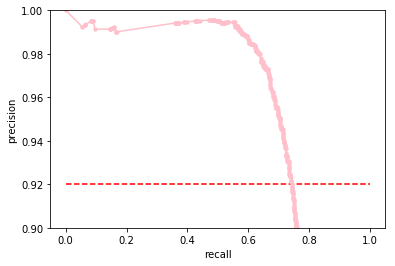

In [22]:
#Precision-Recall Curve; concerned with the prediction of the minority class, which is class 1 ...AKA Stars

precision_ada, recall_ada, thresholds_ada = precision_recall_curve(ytest, prob_gal)
pr_list.append(('adaboost',precision_ada,recall_ada,'blue')) #if not in, then append

plt.plot([0, 1], [0.92, 0.92], linestyle='--',color='red') #no skill line; positive cases / positive + negative = 0.92
plt.plot(recall_ada, precision_ada, marker='.',color='pink')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.9,1])
plt.show()

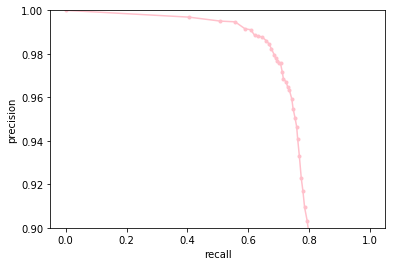

In [23]:
#RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(Xtrain,y)
ypred = clf.predict(Xtest)
prob = clf.predict_proba(Xtest)
prob_gal = [i[1] for i in prob]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(ytest, prob_gal)
plt.plot(recall_rf, precision_rf, marker='.',color='pink')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.9,1])
plt.show()

pr_list.append(('randomforest',precision_rf,recall_rf,'pink'))

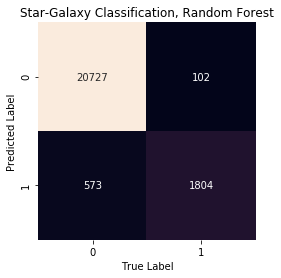

In [24]:
mat = confusion_matrix(ypred,ytest)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts.append((gal_cont,'randomforest'))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
title = 'Star-Galaxy Classification, Random Forest'
plt.title(title)
plt.show()


In [25]:
#DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf.fit(Xtrain,y)
ypred = clf.predict(Xtest)
prob = clf.predict_proba(Xtest)
prob_gal = [i[1] for i in prob]

precision_dt, recall_dt, thresholds_dt = precision_recall_curve(ytest, prob_gal)
pr_list.append(('decision tree',precision_dt,recall_dt,'red'))

In [26]:
mat = confusion_matrix(ypred,ytest)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts.append((gal_cont,'decision tree'))

In [27]:
#ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(Xtrain,y)
ypred = clf.predict(Xtest)
prob = clf.predict_proba(Xtest)
prob_gal = [i[1] for i in prob]

precision_et, recall_et, thresholds_et = precision_recall_curve(ytest, prob_gal)
pr_list.append(('extra trees',precision_et,recall_et,'green'))

In [28]:
mat = confusion_matrix(ypred,ytest)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts.append((gal_cont,'extratrees'))

In [29]:
#KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(Xtrain,y)
ypred = clf.predict(Xtest)
prob = clf.predict_proba(Xtest)
prob_gal = [i[1] for i in prob]

precision_et, recall_et, thresholds_et = precision_recall_curve(ytest, prob_gal)
pr_list.append(('kneighbors',precision_et,recall_et,'purple'))

In [30]:
mat = confusion_matrix(ypred,ytest)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts.append((gal_cont,'kneighbors'))

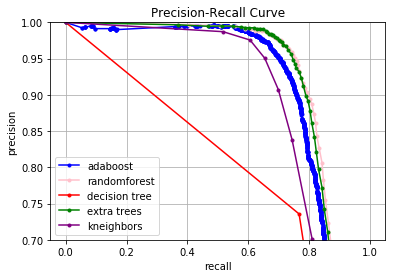

In [31]:
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.7,1])
for plot in pr_list:
    algname = str(plot[0])
    precision=plot[1]
    recall=plot[2]
    color = str(plot[3])
    plt.plot(recall, precision, marker='.',color=color,label=str(algname))
plt.legend()
plt.grid()
plt.title('Precision-Recall Curve')
plt.show()

In [32]:
for cont,name in galaxy_conts:
    print name,":",cont,"% Galaxy Contamination"

adaboost : 3.0 % Galaxy Contamination
randomforest : 2.7 % Galaxy Contamination
decision tree : 2.7 % Galaxy Contamination
extratrees : 3.0 % Galaxy Contamination
kneighbors : 3.3 % Galaxy Contamination


### Same Precision-Recall Curve after magnitude cuts
This is the cut that the Precision-Recall Curve has in the paper. The plot above is for data of all magnitudes.

In [22]:
cond = df['MAG_AUTO_I'] > 24
df_magcut = df[cond]
#newcond = df_interim['MAG_AUTO_I'] < 24
#df_magcut = df_interim[newcond] #database to use for magnitude cuts (17,24)

df_magcut_properties = df_magcut.iloc[:,3:30] #photometric properties
df_magcut_properties['TRUE_CLASS'] = df_magcut['TRUE_CLASS']

rows_mc = len(df_magcut_properties)
Xtrain_mc = df_magcut_properties[:int(rows_mc*0.8)]
Xtest_mc = df_magcut_properties[int(rows_mc*0.8):]

Xtrain_mc = Xtrain_mc.drop("TRUE_CLASS", axis=1)
Xtest_mc = Xtest_mc.drop("TRUE_CLASS", axis=1)

y_mc = df_magcut[:int(rows_mc*0.8)]['TRUE_CLASS']
ytest_mc = df_magcut[int(rows_mc*0.8):]['TRUE_CLASS']

In [23]:
pr_list_mc = []
galaxy_conts_mc = []

In [24]:
#AdaBoost

clf = AdaBoostClassifier(n_estimators=50)
clf.fit(Xtrain_mc,y_mc)
ypred = clf.predict(Xtest_mc)

prob = clf.predict_proba(Xtest_mc)
prob_gal = [i[1] for i in prob]
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(ytest_mc, prob_gal)
pr_list_mc.append(('adaboost',precision_ada,recall_ada,'blue'))

In [25]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts_mc.append((gal_cont,'adaboost'))

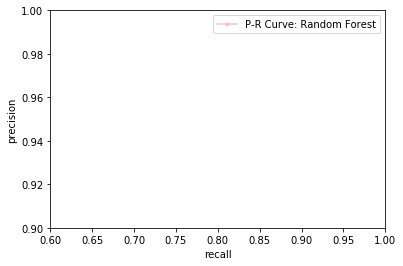

             precision    recall  f1-score   support

   Galaxies       0.96      1.00      0.98      5326
      Stars       0.64      0.10      0.17       215

avg / total       0.95      0.96      0.95      5541



In [26]:
#RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50)
clf.fit(Xtrain_mc,y_mc)
ypred = clf.predict(Xtest_mc)
prob = clf.predict_proba(Xtest_mc)
prob_gal = [i[1] for i in prob]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(ytest_mc, prob_gal)

pr_list_mc.append(('randomforest',precision_rf,recall_rf,'pink'))

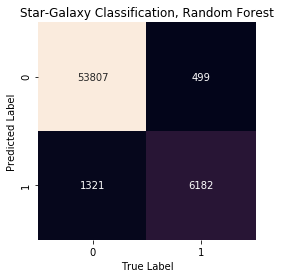

In [38]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts_mc.append((gal_cont,'randomforest'))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
title = 'Star-Galaxy Classification, Random Forest'
plt.title(title)
plt.show()

In [39]:
#DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf.fit(Xtrain_mc,y_mc)
ypred = clf.predict(Xtest_mc)
prob = clf.predict_proba(Xtest_mc)
prob_gal = [i[1] for i in prob]

precision_dt, recall_dt, thresholds_dt = precision_recall_curve(ytest_mc, prob_gal)
pr_list_mc.append(('decision tree',precision_dt,recall_dt,'red'))

In [40]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts_mc.append((gal_cont,'decisiontree'))

In [41]:
#ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(Xtrain_mc,y_mc)
ypred = clf.predict(Xtest_mc)
prob = clf.predict_proba(Xtest_mc)
prob_gal = [i[1] for i in prob]

precision_et, recall_et, thresholds_et = precision_recall_curve(ytest_mc, prob_gal)
pr_list_mc.append(('extra trees',precision_et,recall_et,'green'))

In [42]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts_mc.append((gal_cont,'extratrees'))

In [43]:
#KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(Xtrain_mc,y_mc)
ypred = clf.predict(Xtest_mc)
prob = clf.predict_proba(Xtest_mc)
prob_gal = [i[1] for i in prob]

precision_et, recall_et, thresholds_et = precision_recall_curve(ytest_mc, prob_gal)
pr_list_mc.append(('kneighbors',precision_et,recall_et,'purple'))

In [44]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
galaxy_conts_mc.append((gal_cont,'kneighbors'))

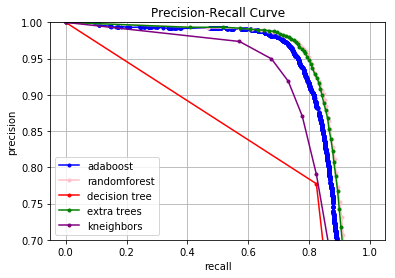

In [45]:
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.7,1])
for plot in pr_list_mc:
    algname = str(plot[0])
    precision=plot[1]
    recall=plot[2]
    color = str(plot[3])
    plt.plot(recall, precision, marker='.',color=color,label=str(algname))
plt.legend()
plt.grid()
plt.title('Precision-Recall Curve')
plt.show()

In [46]:
for cont,name in galaxy_conts_mc:
    print name,":",cont,"% Galaxy Contamination"

adaboost : 2.4 % Galaxy Contamination
randomforest : 2.4 % Galaxy Contamination
decisiontree : 2.5 % Galaxy Contamination
extratrees : 2.6 % Galaxy Contamination
kneighbors : 3.0 % Galaxy Contamination


## PCA

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain_mc)

train_img = scaler.transform(Xtrain_mc)
test_img = scaler.transform(Xtest_mc)

NameError: name 'Xtrain_mc' is not defined

In [3]:
gal_conts_pca = []
pr_pca = []
pca = PCA()
pca.fit(train_img)

train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

clf = AdaBoostClassifier(n_estimators=50)
clf.fit(trainpca,y_mc)
ypred = clf.predict(test_img)

prob = clf.predict_proba(test_img)
prob_gal = [i[1] for i in prob]
precision_ada, recall_ada, thresholds_ada = precision_recall_curve(ytest_mc, prob_gal)
pr_pca.append(('adaboost',precision_ada,recall_ada,'blue'))

plt.plot(recall_ada, precision_ada, marker='.',color='pink')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim([0.9,1])
plt.show()

NameError: name 'train_img' is not defined

In [4]:
mat = confusion_matrix(ypred,ytest_mc)
TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
gal_cont = round((FP/(FP+TP)),3)*100
gal_conts_pca.append((gal_cont,'adaboost'))

NameError: name 'ypred' is not defined

In [ ]:
clf = RandomForestClassifier(n_estimators=50)
clf.fit(trainpca,y_mc)
ypred = clf.predict(testpca)
prob = clf.predict_proba(testpca)


#prob_gal = [i[1] for i in prob]
#precision_rf, recall_rf, thresholds_rf = precision_recall_curve(ytest_mc, prob_gal)
#pr_list_mc.append(('randomforest',precision_rf,recall_rf,'pink'))
#mat = confusion_matrix(ypred,ytest_mc)
#TP, FP, FN, TN = float(mat[0][0]),float(mat[0][1]),float(mat[1][0]),float(mat[1][1])
#gal_cont = round((FP/(FP+TP)),3)*100
#galaxy_conts_mc.append((gal_cont,'randomforest'))

In [ ]:
xplt = []
yplt = []
for x, y in prob:
    xplt.append(x)
    yplt.append(y)
plt.scatter(xplt,yplt)
plt.show()

In [ ]:
from platform import python_version
print(python_version())

In [ ]:
#trying other stuff w/PCA

In [6]:
data = Table.read('sgsep_cosmos_tests_v2.fits', format='fits')
df = data.to_pandas()

np.unique(df['TRUE_CLASS'],return_counts=True)

(array([0, 1], dtype=int16), array([103914,  12113]))

In [7]:
df_properties = df.iloc[:,3:30] #photometric properties
df_properties['TRUE_CLASS'] = df['TRUE_CLASS']

rows = len(df_properties.index)
Xtrain = df_properties[:int(rows*0.8)]
Xtest = df_properties[int(rows*0.8):]

Xtrain = Xtrain.drop("TRUE_CLASS", axis=1)
Xtest = Xtest.drop("TRUE_CLASS", axis=1)

y = df_properties[:int(rows*0.8)]['TRUE_CLASS'] #training
ytest = df_properties[int(rows*0.8):]['TRUE_CLASS']

lst = []
for i in range(len(df_properties.columns)):
    lst.append(df_properties.columns[i])
print lst

['MAG_AUTO_G', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_Z', 'MAG_AUTO_Y', 'MAGERR_AUTO_G', 'MAGERR_AUTO_R', 'MAGERR_AUTO_I', 'MAGERR_AUTO_Z', 'MAGERR_AUTO_Y', 'MAG_CM_MOF_G', 'MAG_CM_MOF_R', 'MAG_CM_MOF_I', 'MAG_CM_MOF_Z', 'MAG_PSF_MOF_G', 'MAG_PSF_MOF_R', 'MAG_PSF_MOF_I', 'MAG_PSF_MOF_Z', 'CONCENTRATION_MOF_G', 'CONCENTRATION_MOF_R', 'CONCENTRATION_MOF_I', 'CONCENTRATION_MOF_Z', 'CLASS_STAR_I', 'SPREAD_MODEL_I', 'SPREADERR_MODEL_I', 'CM_T', 'CM_T_ERR', 'TRUE_CLASS']


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [9]:
pca = PCA(n_components=5)
cls = LogisticRegression() 

pipe = Pipeline([('pca', pca), ('logistic', cls)])
pipe.fit(Xtrain, y)
predictions = pipe.predict(Xtest)
print(np.unique(ytest, return_counts=True))

(array([0, 1], dtype=int16), array([20829,  2377]))


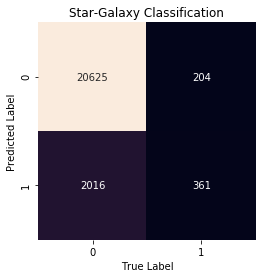

In [10]:
mat = confusion_matrix(predictions,ytest)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
title = 'Star-Galaxy Classification'
plt.title(title)
plt.show()

In [11]:
pca = PCA(n_components=5)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.fit_transform(Xtest)

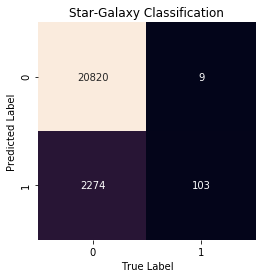

In [12]:
clf = AdaBoostClassifier()
clf.fit(Xtrain_pca, y)
ypred = clf.predict(Xtest_pca)

mat = confusion_matrix(ypred,ytest)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
title = 'Star-Galaxy Classification'
plt.title(title)
plt.show()